### Few Hit Wonders versus Consistent Hitters
##### Joseph Scarpa (jcs140)

In [ ]:
# Imports (update throughout as necessary)
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt # just to format confusion matrix

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

import re

#### Data loading and cleaning

Notes:
* No null values found
* No duplicate values found

In [ ]:
# Data loading
data10 = pd.read_csv('./datasets/dataset-of-10s.csv')
data00 = pd.read_csv('./datasets/dataset-of-00s.csv')
data90 = pd.read_csv('./datasets/dataset-of-90s.csv')
data80 = pd.read_csv('./datasets/dataset-of-80s.csv')
data70 = pd.read_csv('./datasets/dataset-of-70s.csv')
data60 = pd.read_csv('./datasets/dataset-of-60s.csv')

In [ ]:
# Data cleaning

# Drop all na values
data10 = data10.dropna()
data00 = data00.dropna()
data90 = data90.dropna()
data80 = data80.dropna()
data70 = data70.dropna()
data60 = data60.dropna()


# Add a decades column to each dataset (will be helpful when creating cumulative dataset)
data10['decade'] = [2010]*len(data10)
data00['decade'] = [2000]*len(data00)
data90['decade'] = [1990]*len(data90)
data80['decade'] = [1980]*len(data80)
data70['decade'] = [1970]*len(data70)
data60['decade'] = [1960]*len(data60)

In [ ]:
# Check for duplicates in dataset
merged = data10.merge(data00,on=['track','artist'])
merged = merged.merge(data90,on=['track','artist'])
merged = merged.merge(data80,on=['track','artist'])
merged = merged.merge(data70,on=['track','artist'])
merged = merged.merge(data60,on=['track','artist'])
merged
# NOTE: No duplicates found

,uri_x,danceability_x,energy_x,key_x,loudness_x,mode_x,speechiness_x,acousticness_x,instrumentalness_x,liveness_x,...,instrumentalness_y,liveness_y,valence_y,tempo_y,duration_ms_y,time_signature_y,chorus_hit_y,sections_y,target_y,decade_y


In [ ]:
# Create cumulative dataset (from songs across all decades)
data = data10.append(data00,ignore_index=True).append(data90,ignore_index=True).append(data80,ignore_index=True).append(data70,ignore_index=True).append(data60,ignore_index=True)
data.head()
data.tail()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
41101,Le ire di Ursus,Giampiero Boneschi,spotify:track:3dVgolCVuNgecU5jovpc45,0.420,0.8730,3,-11.689,1,0.1000,0.808,0.879000,0.363,0.183,119.821,26244,4,0.00000,2,0,1960
41102,A-B-C,John Zacherle,spotify:track:0zXhzKf4raEYstebL7L42C,0.716,0.7420,10,-5.727,0,0.2420,0.663,0.000000,0.107,0.834,135.104,142987,4,28.34316,10,0,1960
41103,Useless Landscape,Antônio Carlos Jobim,spotify:track:2uC02PCRVM6BhAaK7dgxxp,0.361,0.0944,10,-22.663,1,0.0327,0.940,0.000178,0.115,0.139,92.472,137200,4,56.63498,6,0,1960
41104,Vendedor De Assaí,Ary Lobo,spotify:track:0gpSUWZWNIRrEenaC1ZGk9,0.452,0.7590,4,-7.821,0,0.1750,0.658,0.000000,0.738,0.853,137.976,159107,3,28.24372,9,0,1960
41105,Mambo Simphony - Remasterizado,Orquesta Casino De La Playa,spotify:track:5j0G0nkCSPlmSCSgXchMn3,0.554,0.2780,5,-8.386,1,0.0349,0.928,0.922000,0.136,0.428,131.401,164227,4,37.39251,8,0,1960


In [ ]:
# Add custom columns that will be useful later

# Duration of song in seconds
data["duration_sec"] = np.round(data["duration_ms"]*(1/1000))
data["duration_sec"]

# Loudness of sound (rounded)
data["loudness_rounded"] = np.round(data["loudness"])
data["loudness_rounded"]

0        -5.0
1       -15.0
2        -7.0
3        -6.0
4        -4.0
         ... 
41101   -12.0
41102    -6.0
41103   -23.0
41104    -8.0
41105    -8.0
Name: loudness_rounded, Length: 41106, dtype: float64

In [ ]:
#Clone dataset
artistsModData = data.copy()
artistsModData = artistsModData.loc[artistsModData['target'] == 1].reset_index(drop=True)
artistsModData.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,duration_sec,loudness_rounded
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,...,0.706,108.029,188493,4,41.18681,10,1,2010,188.0,-5.0
1,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,...,0.274,172.065,205463,4,44.89147,9,1,2010,205.0,-7.0
2,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,...,0.780,160.517,144244,4,24.99199,8,1,2010,144.0,-4.0
3,Here's To Never Growing Up,Avril Lavigne,spotify:track:0qwcGscxUHGZTgq0zcaqk1,0.482,0.873,0,-3.145,1,0.0853,0.01110,...,0.737,165.084,214320,4,32.17301,12,1,2010,214.0,-3.0
4,Helluva Night,Ludacris,spotify:track:0flKDWZq11997Fb2ptkQvu,0.736,0.522,2,-8.020,1,0.1160,0.02990,...,0.369,97.547,200387,4,60.21027,10,1,2010,200.0,-8.0


In [ ]:
# One-hit wonders versus Staying Power

#Cleaning data
artistsModData['artist'] = artistsModData['artist'].str.replace(r"\(.*\)","")
artistsModData.head()

for i in range(len(artistsModData)):
    artistsModData['artist'][i] = re.split(" [fF][eE][aA][tT]", artistsModData['artist'][i])[0]

# Count Data
artistsCountData = artistsModData.groupby('artist').count().sort_values(by = 'uri' ,ascending=False)
artistsCountData = artistsCountData["track"].reset_index()
artistsCountData = artistsCountData.rename(columns = {'track' : 'counts'})


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
# Get percentiles
#https://www.datasciencemadesimple.com/percentile-rank-column-pandas-python-2/

#Explore
three_or_less = artistsCountData['counts'].quantile(.65912)
print(three_or_less)
print(artistsCountData['counts'].mean())

#Make percentile column
artistsCountData['percentile'] = artistsCountData['counts'].rank(pct=True)

#Is Consistent Hitter Versus One Time Hitter
artistsCountData['one_timer'] = (artistsCountData['percentile'] < .65912).astype(int)

merger = artistsCountData[['artist', 'one_timer']]

print(merger.columns)

3.0
3.751916757940854
Index(['artist', 'one_timer'], dtype='object')


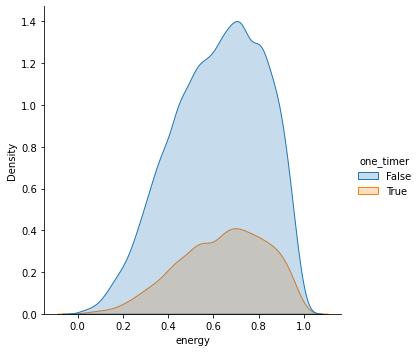

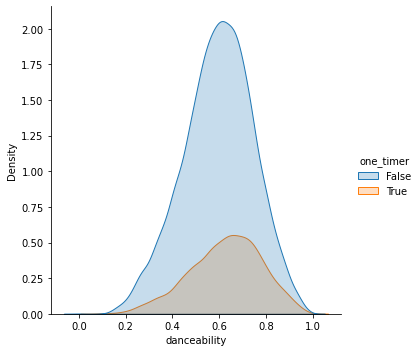

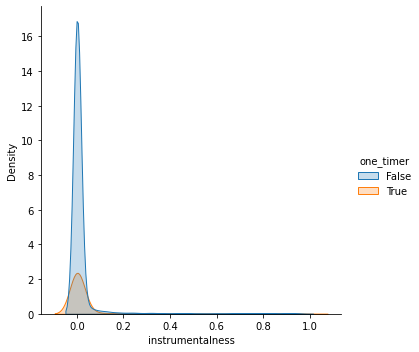

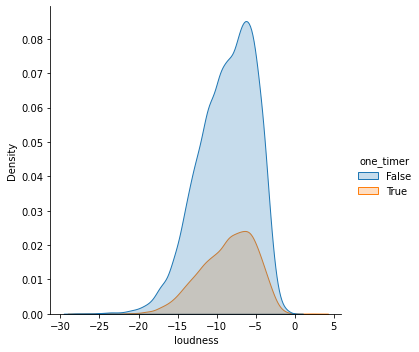

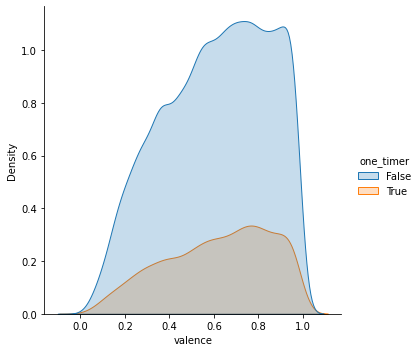

In [ ]:
# Merge with hits 
#to analyze difference in hits between 3 or less timers and consistent hitters

artistsModDataR = pd.merge(merger, artistsModData, on = "artist", how = 'inner')

artistsModDataR['one_timer'] = artistsModDataR['one_timer'].astype('bool')
sns.displot(artistsModDataR , x="energy", hue="one_timer", kind="kde", fill=True)
sns.displot(artistsModDataR , x="danceability", hue="one_timer", kind="kde", fill=True)
sns.displot(artistsModDataR , x="instrumentalness", hue="one_timer", kind="kde", fill=True)
# Non picked factors: 
sns.displot(artistsModDataR , x="loudness", hue="one_timer", kind="kde", fill=True)
sns.displot(artistsModDataR , x="valence", hue="one_timer", kind="kde", fill=True)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=162d76af-48a2-4f75-9aef-34643a48aa39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>